# Image Classifier from Scratch

# 1. Import libraries

In [3]:
%cd transformer-for-image-classification
!pip install torchinfo

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
import requests
from torchvision import transforms

from modules.data_prep import create_dataloaders
from modules.evaluation import show_losses_and_accs
from modules.prediction import pred_and_plot_image
from modules.others import plot_an_image

from modules.others import set_seeds, save_model
from modules.model import PatchEmbedding, TransformerEncoderBlock, ViTBlock
from modules.train_prep import train

from torchinfo import summary

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Load dataset
!unzip data/flower_photos.zip -d data/

# 2. Create DataLoaders

In [5]:
# Setup parameters to train and test images
path = "data/flower_photos"
IMG_SIZE = 224 # image siz
BATCH_SIZE = 32 # batch size

# Create transform pipeline manually
image_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(root_path=path, transform=image_transforms, batch_size=BATCH_SIZE)

print(f"Manually created transforms: {image_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


# 3. Preprocess and plot an image

Patch + token + position embeddings: torch.Size([1, 197, 768])


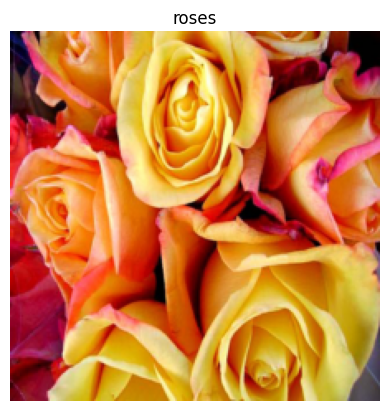

In [7]:
# Set seeds
set_seeds()

# Set image patch size
patch_size = 16

# Visualize a image
plot_an_image(train_dataloader, class_names, patch_size)

# 4. Show the model

In [8]:
transformer_encoder_block = TransformerEncoderBlock()
summary(model=transformer_encoder_block, input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20,row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (mha_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# 5. Train the model

In [9]:
# Create the model
vit = ViTBlock(num_classes=len(class_names))

# Setup the optimizer to optimize
optimizer = torch.optim.Adam(params=vit.parameters(), lr=3e-3, # ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values Training & Fine-tuning)
                             weight_decay=0.3) # ViT-* ImageNet-1k

# Setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = train(model=vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8649 | train_acc: 0.2149 | test_loss: 1.6233 | test_acc: 0.2314
Epoch: 2 | train_loss: 1.6511 | train_acc: 0.2182 | test_loss: 1.6570 | test_acc: 0.2314
Epoch: 3 | train_loss: 1.6155 | train_acc: 0.2297 | test_loss: 1.6193 | test_acc: 0.2314
Epoch: 4 | train_loss: 1.6073 | train_acc: 0.2355 | test_loss: 1.6183 | test_acc: 0.2314
Epoch: 5 | train_loss: 1.6016 | train_acc: 0.2317 | test_loss: 1.6071 | test_acc: 0.2112
Epoch: 6 | train_loss: 1.6020 | train_acc: 0.2382 | test_loss: 1.6060 | test_acc: 0.2314
Epoch: 7 | train_loss: 1.6017 | train_acc: 0.2478 | test_loss: 1.6056 | test_acc: 0.2314
Epoch: 8 | train_loss: 1.6020 | train_acc: 0.2480 | test_loss: 1.6056 | test_acc: 0.2314
Epoch: 9 | train_loss: 1.6023 | train_acc: 0.2478 | test_loss: 1.6058 | test_acc: 0.2314
Epoch: 10 | train_loss: 1.6025 | train_acc: 0.2480 | test_loss: 1.6059 | test_acc: 0.2314


In [10]:
# Save the model
save_model(model=vit, target_dir="models", model_name="img_classifier_from_scratch.pth")

[INFO] Saving model to: models/img_classifier_from_scratch.pth


# 6. Evaluation

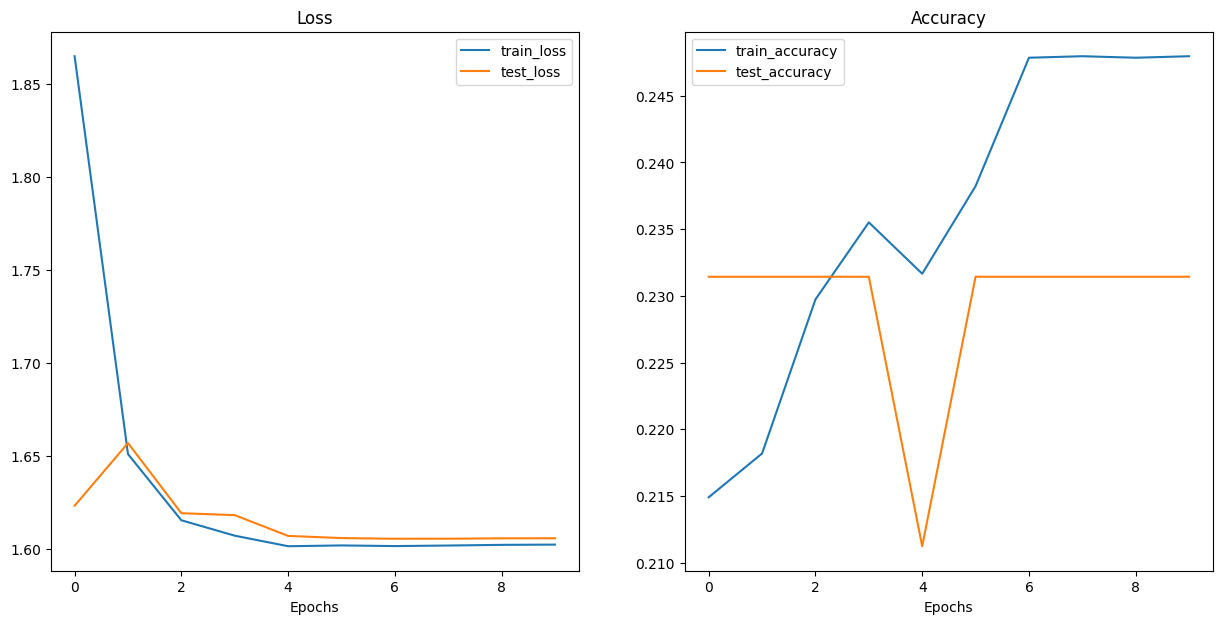

In [11]:
# Plot the losses and accs
show_losses_and_accs(results)

# 7. Predict the results

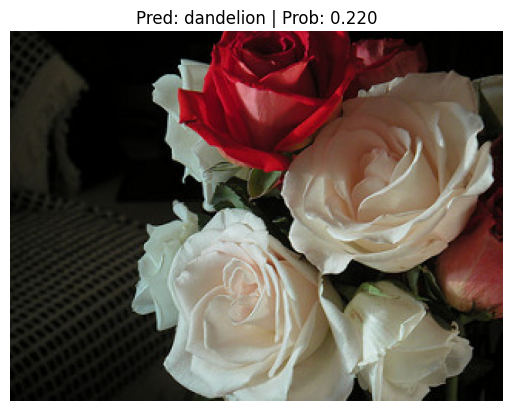

In [12]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on an image
image_path = path + "/roses/102501987_3cdb8e5394_n.jpg"
pred_and_plot_image(model=vit, image_path=image_path, class_names=class_names)

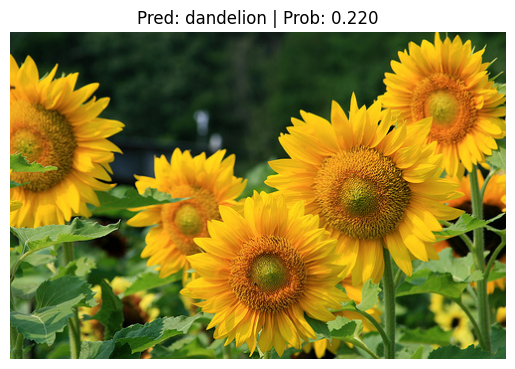

In [13]:
# Predict on an image
image_path_1 = image_path = path + "/sunflowers/1008566138_6927679c8a.jpg"
pred_and_plot_image(model=vit, image_path=image_path_1, class_names=class_names)